# Reducing Risk: A Data-Driven Approach to Traffic Accident Mitigation in the U.S.



## 1. Overview

**1.1 Bottom Line Up Front:**
This project analyzes a large-scale dataset of U.S. traffic accidents to determine when, where, and under what conditions accidents occur—and which infrastructure features influence accident severity. The goal is to provide clear, actionable insights for reducing traffic collisions and their consequences.

**1.2 Key Early Insights:**
- Peak hours (7–9 AM, 3–6 PM) and are high-risk periods for accidents, aligning with commuter patterns. Friday and Thursday tend to exhibit higher accident frequencies, potentially due to weekend transitions.

- Junctions and intersections are associated with higher accident severity, while traffic calming features reduce severity.
- Contrary to expectation, environmental conditions like poor weather and low visibility do not significantly impact severity, suggesting drivers may adjust behavior in such conditions.

These findings can help transportation agencies strategically allocate enforcement, redesign infrastructure, and improve public safety campaigns, enhancing both safety outcomes and return on investment.

**1.3 Dataset Overview:**

The analysis is based on the US Accidents Dataset (https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents), which covers approximately 7.7 million accident records across 49 U.S. states from February 2016 to March 2023. The data was collected in real-time through multiple APIs drawing from DOT reports, law enforcement, traffic cameras, and sensors.

- Moosavi et al., “A Countrywide Traffic Accident Dataset,” 2019
- Moosavi et al., “Accident Risk Prediction based on Heterogeneous Sparse Data,” ACM SIGSPATIAL, 2019

## 2. Business Understanding

**2.1 Relevance of the Data**

The US Accidents dataset provides nationwide records with rich detail on time, location, weather, visibility, and road infrastructure for each incident, along with a 1–4 accident severity scale. Its breadth enables multi-factor analysis to identify key contributors to traffic accidents—essential for evidence-based safety improvements.

**2.2 Analytical Questions**

To guide road safety strategy, the analysis addresses:
1. When and where are accidents most frequent? (e.g., peak hours, states, cities)
2. Which environmental conditions (weather, visibility, lighting) increase accident risk or severity?
3. What road features (e.g., junctions, signals) are linked to more severe crashes?

**2.3 Goals & Benefits**

The aim is to generate three data-driven recommendations to help:

- Target high-risk times/locations with focused interventions

- Redesign hazardous infrastructure

- Improve responses to weather-related risks

These insights can reduce crash rates, save lives, and guide smarter resource use.

**2.4 Stakeholders**

- DOT & Safety Agencies – for policy and enforcement

- Urban Planners – for road design and improvements

- Emergency Services – for optimized readiness and response



## 3. Data Understanding

###3.1 Data and Library Loading:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load relevant imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from scipy.stats import ttest_ind
import statsmodels

In [ ]:
# Load CSV as chunks
csv_path = '/content/drive/MyDrive/US_Accidents_March23.csv'

chunks = pd.read_csv(csv_path, chunksize=500_000) #here we processed the data in chunks as there are over 7M rows to inspec the head()
for chunk in chunks:
    # Process each chunk
    print(chunk.head())

    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           False          F

###3.2 Create and Inspect a Sample Dataset on dataset structure and scope (~1% of each chunk to preserve diversity)

Due to the dataset size (over 3GB, 7M+ records), loading it in full exceeded memory limits in Google Colab. To ensure manageable analysis while retaining representativeness, a 1% random sample was taken from each chunk of 500,000 rows.

Sampling per chunk (rather than from the whole) ensures the sample includes a balanced representation of temporal and geographic variations (e.g., winter vs. summer, different cities/states).

The sample dataset is saved as "us_accidents_sample.csv" which is uploaded to my GitHub Repository under /Dataset.



In [ ]:
#Create a representative sample (~1% of each chunk to preserve diversity in e.g. seasons, locations, severities)
sampled_df = pd.DataFrame()

# Create 1% sample from each chunk
for chunk in pd.read_csv(csv_path, chunksize=500_000):
    sampled = chunk.sample(frac=0.01, random_state=42)
    sampled_df = pd.concat([sampled_df, sampled], ignore_index=True)

# Save for future use
sampled_df.to_csv("us_accidents_sample.csv", index=False)


In [ ]:
#download us_accidents_sample.csv
from google.colab import files
files.download("us_accidents_sample.csv")

In [ ]:
#Load and inspect sample data
sample_df = pd.read_csv("us_accidents_sample.csv")
print(sample_df.shape)
sample_df.info()
sample_df.head()

(77284, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77284 entries, 0 to 77283
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     77284 non-null  object 
 1   Source                 77284 non-null  object 
 2   Severity               77284 non-null  int64  
 3   Start_Time             77284 non-null  object 
 4   End_Time               77284 non-null  object 
 5   Start_Lat              77284 non-null  float64
 6   Start_Lng              77284 non-null  float64
 7   End_Lat                43278 non-null  float64
 8   End_Lng                43278 non-null  float64
 9   Distance(mi)           77284 non-null  float64
 10  Description            77283 non-null  object 
 11  Street                 77180 non-null  object 
 12  City                   77282 non-null  object 
 13  County                 77284 non-null  object 
 14  State                  77284 non-null  obj

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-104248,Source2,2,2016-04-25 17:18:11,2016-04-25 18:18:11,33.939304,-117.218231,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
1,A-199683,Source2,2,2017-01-10 09:40:16,2017-01-10 10:10:02,42.549671,-71.847313,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-140206,Source2,3,2016-09-02 17:27:56,2016-09-02 18:27:56,26.203491,-80.143852,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
3,A-132821,Source2,2,2016-09-29 18:07:37,2016-09-29 18:51:28,27.440348,-82.575432,NaN,NaN,0.00,...,False,False,False,False,True,False,Day,Day,Day,Day
4,A-408710,Source2,3,2017-05-03 12:12:18,2017-05-03 12:44:00,33.901752,-118.370316,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [ ]:
#Check feature types and unique counts
sample_df.nunique().sort_values(ascending=True)

###3.3 Identify Data Quality Issues

In [ ]:
#Missing values:
missing = sample_df.isna().mean().sort_values(ascending=False)
print(f"Missing values in percentage:\n", missing [missing > 0]*100)

#Outliers:
sample_df['Distance(mi)'].describe()
sample_df['Distance(mi)'].hist(bins=100)
sample_df['Temperature(F)'].describe()

## 4. Data Preparation

###4.1 Define functions 1-5 to:

1. Drop unecessary columns
2. Parse datetimes, drop invalids, create duration
3. Remove outliers
4. Handle missing values
5. Feature engineering (Hour, DayofWeek, Is_Weekend, etc.)

In [ ]:
#Function 1: Drop unecessary columns
def select_relevant_columns(df):
    columns_to_keep = [
        # Core time and location
        'Start_Time', 'End_Time', 'Severity', 'Start_Lat', 'Start_Lng', 'City', 'State', 'Distance(mi)',

        # Weather/environment
        'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Precipitation(in)',
        'Wind_Speed(mph)', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset',

        # Road/infrastructure features
        'Junction', 'Traffic_Signal', 'Crossing', 'Stop', 'Station',
        'Traffic_Calming', 'Roundabout', 'Bump', 'Give_Way', 'No_Exit', 'Railway', 'Amenity'
    ]

    df = df[columns_to_keep].copy()
    return df

Documentation: Columns Dropped and Reasoning
- ID — unique identifier; not useful for analysis
- Source — not relevant unless comparing data quality
- Country — only has 1 unique value
- Turning_Loop — extremely rare (appears once)
- End_Lat, End_Lng — usually missing and redundant with Start
- Description — free text, not usable without NLP
- Airport_Code — not needed unless geolocating stations
- Street — very granular, too high cardinality
- Zipcode — drop unless you're doing fine-grained spatial analysis
- Timezone — can be derived from location
- Weather_Timestamp — not analyzing lag between event and weather


In [ ]:
# Function 2 : Parse dates, drop invalids, create duration column:
def prepare_datetime_and_duration(df, verbose=True):
    df = df.copy()

    # STEP 1: Convert datetime columns safely
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce', format='mixed')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce', format='mixed')

    # STEP 2: Drop rows with invalid/missing datetime values
    before_time_drop = len(df)
    df = df.dropna(subset=['Start_Time', 'End_Time'])
    after_time_drop = len(df)

    # STEP 3: Create duration in hours
    df['Duration_Hours'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 3600

    #STEP 4: Drop rows with missing cities - important for location-based analysis before imputing with median
    before_city_drop = len(df)
    df = df.dropna(subset=['City'])
    after_city_drop = len(df)

    if verbose:
        print(f"Dropped {before_time_drop - after_time_drop} rows with invalid/missing datetime values")
        print(f"Dropped {before_city_drop - after_city_drop} rows with missing 'City'")
    return df

In [ ]:
#Function 3: Define and Drop Outliers
def remove_outliers(df, drop=True, verbose=True):
    df = df.copy()

    # --- Create duration column if not already present ---
    if 'Duration_Hours' not in df.columns:
      df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce', format='mixed')
      df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce', format='mixed')
      df['Duration_Hours'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 3600


    # --- Define thresholds for outliers ---
    conditions = {
        'Distance(mi)': lambda x: (x > 100) | (x < 0.01),
        'Duration_Hours': lambda x: (x > 12) | (x < 0),
        'Temperature(F)': lambda x: (x < -50) | (x > 130),
        'Humidity(%)': lambda x: (x < 0) | (x > 100),
        'Visibility(mi)': lambda x: (x > 50),
        'Wind_Speed(mph)': lambda x: (x > 100),
        'Start_Lat': lambda x: (x < 24) | (x > 49),
        'Start_Lng': lambda x: (x < -125) | (x > -66)
    }

    # --- Initialize outlier mask ---
    outlier_mask = pd.Series(False, index=df.index)

    # --- Apply each condition ---
    outlier_summary = {}
    for col, condition in conditions.items():
        col_outliers = condition(df[col])
        outlier_mask |= col_outliers
        outlier_summary[col] = int(col_outliers.sum())

    if verbose:
        print("Outlier Summary:")
        for k, v in outlier_summary.items():
            print(f"  - {k}: {v} rows flagged")

    # --- Drop or return with mask ---
    if drop:
        cleaned_df = df[~outlier_mask].reset_index(drop=True)
        print(f"\nCleaned dataset: {len(df)} → {len(cleaned_df)} rows after outlier removal")
        return cleaned_df
    else:
        df['is_outlier'] = outlier_mask
        return df

Documentation: Reference for Outlier Threshold for Specific Features
- Distance (mi): > 100 or == 0                        
- Duration (hours): > 12 or < 0    
- Temperature (F): < -50 or > 130
- Humidity (%): < 0 or > 100
- Visibility (mi): > 50
- Wind Speed (mph): > 100    
- Latitude / Longitude: Outside U.S. bounds (24–49, -125 to -66)



In [ ]:
#Function 4: Handle Missing Values
def handle_missing_values(df, missing_threshold=0.4, verbose=True):
    df = df.copy()

    # --- Step 1: Impute numeric columns with median ---
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        if df[col].isna().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            if verbose:
                print(f"Imputed numeric column '{col}' with median = {median_val:.2f}")

    # --- Step 2: Impute categorical columns with mode ---
    categorical_cols = df.select_dtypes(include='object').columns
    for col in categorical_cols:
        if df[col].isna().any():
            mode_val = df[col].mode(dropna=True)
            if not mode_val.empty:
                df[col] = df[col].fillna(mode_val[0])
                if verbose:
                    print(f"Imputed categorical column '{col}' with mode = {mode_val[0]}")

    return df


In [ ]:
# Function 5: Feature Engineering
def engineer_features(df, verbose=True):
    df = df.copy()

    # --- TIME-BASED FEATURES from Start_Time ---
    df['Hour'] = df['Start_Time'].dt.hour
    df['DayOfWeek'] = df['Start_Time'].dt.day_name()
    df['Month'] = df['Start_Time'].dt.month
    df['Year'] = df['Start_Time'].dt.year

    df['Is_Weekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday'])
    df['Is_Rush_Hour'] = df['Hour'].between(7, 9) | df['Hour'].between(16, 18)

    # --- LIGHT CONDITION FEATURE ---
    df['Is_Night'] = df['Sunrise_Sunset'].str.lower() == 'night'

    # --- WEATHER SEVERITY GROUPING --- Documentation: I later realized this was not a meaningful grouping method in the EDA step and tried another grouping
    def map_weather_condition(condition):
        if not isinstance(condition, str):
            return 'Unknown'

        condition = condition.lower()

        if any(word in condition for word in ['fair', 'clear', 'partly cloudy']):
            return 'Clear'
        elif any(word in condition for word in ['cloudy', 'overcast', 'fog', 'haze', 'mist', 'drizzle']):
            return 'Cloudy/Mist'
        elif any(word in condition for word in ['rain', 'snow', 'wintry', 'shower', 'freezing']):
            return 'Rain/Snow'
        elif any(word in condition for word in ['storm', 't-storm', 'thunder', 'smoke', 'blowing', 'squalls']):
            return 'Severe'
        else:
            return 'Other'

    df['Weather_Severity'] = df['Weather_Condition'].apply(map_weather_condition).astype('category')

    if verbose:
        print("Engineered Features Added:")
        print(" - Hour, DayOfWeek, Month, Year")
        print(" - Is_Weekend, Is_Rush_Hour")
        print(" - Is_Night (from Sunrise_Sunset)")
        print(" - Weather_Severity (Clear / Cloudy/Mist / Rain/Snow / Severe / Other)")

    return df


###4.2 Call functions and summarize data:

In [ ]:
#Function Calls:
#1. Drop unecessary columns
sample_df = select_relevant_columns(sample_df)
#2. Parse datetimes, drop invalids, create duration
sample_df_cleaned= prepare_datetime_and_duration(sample_df)
#3. Remove outliers
sample_df_cleaned = remove_outliers(sample_df_cleaned)
#4. Handle missing values
sample_df_cleaned = handle_missing_values(sample_df_cleaned)
#5. Feature engineering (Hour, DayofWeek, Is_Weekend, etc.)
sample_df_cleaned = engineer_features(sample_df_cleaned)

Dropped 0 rows with invalid/missing datetime values
Dropped 2 rows with missing 'City'
Outlier Summary:
  - Distance(mi): 33859 rows flagged
  - Duration_Hours: 939 rows flagged
  - Temperature(F): 0 rows flagged
  - Humidity(%): 0 rows flagged
  - Visibility(mi): 14 rows flagged
  - Wind_Speed(mph): 1 rows flagged
  - Start_Lat: 0 rows flagged
  - Start_Lng: 0 rows flagged

Cleaned dataset: 77282 → 42503 rows after outlier removal
Imputed numeric column 'Temperature(F)' with median = 63.00
Imputed numeric column 'Humidity(%)' with median = 66.00
Imputed numeric column 'Pressure(in)' with median = 29.82
Imputed numeric column 'Visibility(mi)' with median = 10.00
Imputed numeric column 'Precipitation(in)' with median = 0.00
Imputed numeric column 'Wind_Speed(mph)' with median = 7.00
Imputed categorical column 'Wind_Direction' with mode = CALM
Imputed categorical column 'Weather_Condition' with mode = Fair
Imputed categorical column 'Sunrise_Sunset' with mode = Day
Engineered Features Ad

In [ ]:
sample_df_cleaned.head()
sample_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42503 entries, 0 to 42502
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Start_Time         42503 non-null  datetime64[ns]
 1   End_Time           42503 non-null  datetime64[ns]
 2   Severity           42503 non-null  int64         
 3   Start_Lat          42503 non-null  float64       
 4   Start_Lng          42503 non-null  float64       
 5   City               42503 non-null  object        
 6   State              42503 non-null  object        
 7   Distance(mi)       42503 non-null  float64       
 8   Temperature(F)     42503 non-null  float64       
 9   Humidity(%)        42503 non-null  float64       
 10  Pressure(in)       42503 non-null  float64       
 11  Visibility(mi)     42503 non-null  float64       
 12  Precipitation(in)  42503 non-null  float64       
 13  Wind_Speed(mph)    42503 non-null  float64       
 14  Wind_D

In [ ]:
#Check Basic Descriptive Stats for Numerical Columns and Value Counts for Categorical Features:
print("\n📊Numerical Feature Summary:\n")
display(sample_df_cleaned.describe().T)

categorical_cols = sample_df_cleaned.select_dtypes(include='object').columns.tolist()
categorical_cols += sample_df_cleaned.select_dtypes(include='category').columns.tolist()

for col in categorical_cols:
    print(f"\n📘Value Counts for '{col}':")
    print(sample_df_cleaned[col].value_counts(dropna=False).head(10))


📊Numerical Feature Summary:



,count,mean,min,25%,50%,75%,max,std
Start_Time,42503,2021-01-26 21:14:37.520857600,2016-02-11 05:30:51,2020-09-25 17:39:00,2021-09-23 15:56:30,2022-06-13 14:56:24.500000,2023-03-31 21:17:00,NaN
End_Time,42503,2021-01-26 23:28:42.102407168,2016-02-11 06:00:51,2020-09-25 22:14:06.500000,2021-09-23 17:41:00,2022-06-13 18:00:07.500000,2023-03-31 23:27:02,NaN
Severity,42503.0,2.171282,1.0,2.0,2.0,2.0,4.0,0.483628
Start_Lat,42503.0,36.347751,24.570231,33.426209,36.744021,40.372892,48.894487,5.289947
Start_Lng,42503.0,-94.685333,-124.493147,-117.357183,-86.844415,-80.174929,-68.77883,17.838765
Distance(mi),42503.0,1.002797,0.01,0.097,0.366,1.024,99.952,2.191655
Temperature(F),42503.0,60.670915,-35.0,48.0,63.0,75.0,120.0,19.171178
Humidity(%),42503.0,64.316636,1.0,48.0,66.0,83.0,100.0,22.592393
Pressure(in),42503.0,29.481634,19.46,29.32,29.82,30.01,38.44,1.05347
Visibility(mi),42503.0,9.057616,0.0,10.0,10.0,10.0,50.0,2.579242



📘Value Counts for 'City':
City
Miami          1434
Los Angeles     844
Orlando         801
Dallas          700
Houston         671
Charlotte       398
Sacramento      355
Austin          344
San Diego       341
Minneapolis     327
Name: count, dtype: int64

📘Value Counts for 'State':
State
CA    9887
FL    5810
TX    2529
NY    2116
VA    2076
PA    1961
SC    1432
NC    1373
OR    1312
MN    1295
Name: count, dtype: int64

📘Value Counts for 'Wind_Direction':
Wind_Direction
CALM    7085
S       2554
W       2485
WNW     2216
NW      2170
SSW     2135
WSW     1949
N       1939
SW      1926
NNW     1885
Name: count, dtype: int64

📘Value Counts for 'Weather_Condition':
Weather_Condition
Fair                17378
Mostly Cloudy        5445
Cloudy               5039
Partly Cloudy        3456
Clear                2822
Light Rain           1906
Overcast             1463
Light Snow            862
Scattered Clouds      696
Fog                   573
Name: count, dtype: int64

📘Value Counts for '

In [ ]:
#Summarize infrastructure columns like Junction, Traffic Signal, Stop (booleans)
def summarize_boolean_columns(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include='bool').columns.tolist()

    print("🚦 Infrastructure & Boolean Feature Summary:\n")

    summary = []
    total = len(df)

    for col in cols:
        true_count = df[col].sum()
        false_count = total - true_count
        true_pct = 100 * true_count / total
        false_pct = 100 * false_count / total

        summary.append({
            'Feature': col,
            'True Count': true_count,
            'True %': f"{true_pct:.2f}%",
            'False Count': false_count,
            'False %': f"{false_pct:.2f}%"
        })

    import pandas as pd
    summary_df = pd.DataFrame(summary)
    display(summary_df.sort_values(by='False Count', ascending=False))

summarize_boolean_columns(sample_df_cleaned)


🚦 Infrastructure & Boolean Feature Summary:



,Feature,True Count,True %,False Count,False %
6,Roundabout,1,0.00%,42502,100.00%
7,Bump,27,0.06%,42476,99.94%
5,Traffic_Calming,38,0.09%,42465,99.91%
9,No_Exit,93,0.22%,42410,99.78%
8,Give_Way,120,0.28%,42383,99.72%
10,Railway,328,0.77%,42175,99.23%
11,Amenity,439,1.03%,42064,98.97%
3,Stop,985,2.32%,41518,97.68%
4,Station,988,2.32%,41515,97.68%
1,Traffic_Signal,3382,7.96%,39121,92.04%


In [ ]:
missing_percent = sample_df_cleaned.isna().mean().sort_values(ascending=False) * 100
missing_percent = missing_percent[missing_percent > 0]

if not missing_percent.empty:
    print("\n❗ Remaining Missing Data (%):")
    print(missing_percent)
else:
    print("\n✅ No remaining missing values.")


✅ No remaining missing values.


## 5. EDA

- Conduct analysis driven by your business questions in step 2.
- Create different visualizations to illustrate your findings.
- Include clear interpretations for each visualization.
- Document any surprising findings or counterintuitive patterns.

### 0. Basic Exploration: correlation matrix and Accident Duration vs. Severity

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(sample_df_cleaned.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

"""Findings: Most variables have a very weak correlation with Severity (all between -0.05 and 0.08). Year has the highest absolute correlation with severity (-0.32) which suggests a decline in severity over time, possibly due to better infrastructure or policy.
This weak correlation confirms that accident severity is likely not driven by any one single numeric feature but a combination of conditions. It supports Q2 (weather and environment effects).
"""

### Question 1: When and where do most accidents occur?


In [ ]:
#1. When do most accidents occur?

# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(16, 10))

# --- 1. Accidents by Hour of Day ---
plt.subplot(2, 2, 1)
sns.countplot(x='Hour', data=sample_df_cleaned, color='skyblue')
plt.title('Accidents by Hour of Day')
plt.xlabel('Hour (0–23)')
plt.ylabel('Count')

# --- 2. Accidents by Day of Week ---
plt.subplot(2, 2, 2)
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='DayOfWeek', data=sample_df_cleaned, order=ordered_days, color='lightgreen')
plt.title('Accidents by Day of Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=45)

# --- 3. Accidents by Month ---
plt.subplot(2, 1, 2)
sns.countplot(x='Month', data=sample_df_cleaned, color='salmon')
plt.title('Accidents by Month')
plt.xlabel('Month (1–12)')
plt.ylabel('Count')

# Layout
plt.tight_layout()
plt.show()

In [ ]:
#2. Where do they occur?
# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(14, 8))

# --- 1. Top 10 Cities with Most Accidents ---
plt.subplot(1, 2, 1)
top_cities = sample_df_cleaned['City'].value_counts().nlargest(10)
sns.barplot(y=top_cities.index, x=top_cities.values, palette='mako')
plt.title('Top 10 Cities with Most Accidents')
plt.xlabel('Accident Count')
plt.ylabel('City')

# --- 2. Top 10 States with Most Accidents ---
plt.subplot(1, 2, 2)
top_states = sample_df_cleaned['State'].value_counts().nlargest(10)
sns.barplot(y=top_states.index, x=top_states.values, palette='rocket')
plt.title('Top 10 States with Most Accidents')
plt.xlabel('Accident Count')
plt.ylabel('State')

# Layout
plt.tight_layout()
plt.show()

### Question 2. Environmental conditions / accident severity


In [ ]:
# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(18, 12))

# --- 1. Severity vs Weather Condition ---
plt.subplot(2, 2, 1)
top_weather = sample_df_cleaned['Weather_Condition'].value_counts().nlargest(10).index
sns.boxplot(
    data=sample_df_cleaned[sample_df_cleaned['Weather_Condition'].isin(top_weather)],
    x='Weather_Condition', y='Severity', palette='coolwarm'
)
plt.title('Severity by Weather Condition (Top 10)')
plt.xlabel('Weather Condition')
plt.ylabel('Severity')
plt.xticks(rotation=45)

# --- 2. Severity vs Visibility ---
plt.subplot(2, 2, 2)
sns.boxplot(data=sample_df_cleaned, x='Severity', y='Visibility(mi)', palette='Blues')
plt.title('Visibility vs Severity')
plt.xlabel('Severity')
plt.ylabel('Visibility (miles)')

# --- 3. Severity vs Precipitation ---
plt.subplot(2, 2, 3)
sns.boxplot(data=sample_df_cleaned, x='Severity', y='Precipitation(in)', palette='Purples')
plt.title('Precipitation vs Severity')
plt.xlabel('Severity')
plt.ylabel('Precipitation (inches)')

# --- 4. Day vs Night Accidents by Severity ---
plt.subplot(2, 2, 4)
sns.countplot(data=sample_df_cleaned, x='Sunrise_Sunset', hue='Severity', palette='Set2')
plt.title('Severity by Day vs Night')
plt.xlabel('Time of Day')
plt.ylabel('Accident Count')

# Layout
plt.tight_layout()
plt.show()

#### Personal Challenge/ Thoughts documentation: Evaluation of Weather Severity Grouping:

I visualized Accident Severity vs. Weather Severity (my own mapping) to evaluate the validity and usefulness of grouping 77 distinct Weather_Condition values into 5 broader Weather_Severity categories: Clear, Cloudy/Mist, Rain/Snow, Other, and Severe.

Although "Other" accounts for only 1.72% of the total records, the chart reveals that it dominates the severity distribution, showing much higher variability and a broader range of accident severities. This undermines the purpose of grouping, as "Other" appears to have absorbed too many distinct or misclassified weather types, reducing interpretability and masking important patterns.

/tmp/ipython-input-20-530517909.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


,proportion
Weather_Severity,
Clear,56.388961
Cloudy/Mist,31.416606
Rain/Snow,9.286403
Other,1.724584
Severe,1.183446


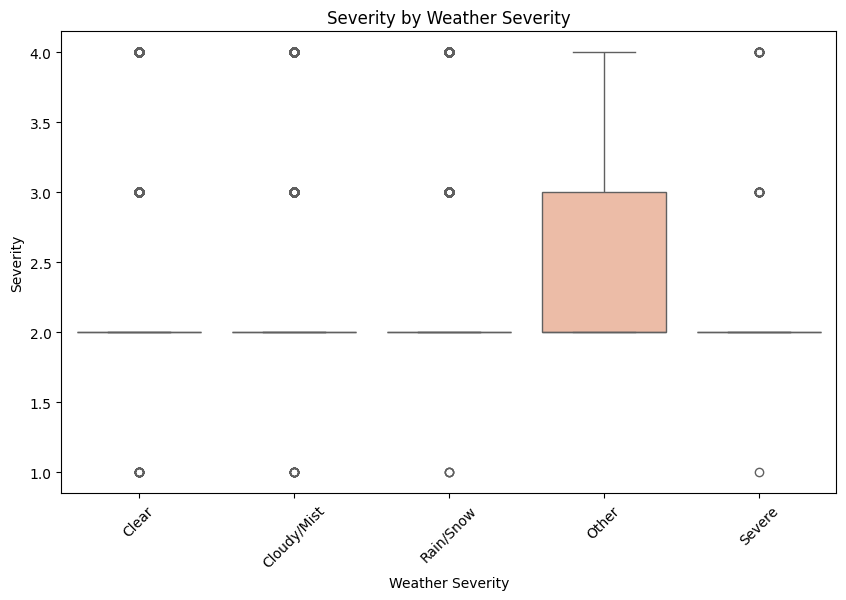

In [ ]:
# --- Severity vs Weather Severity ---
plt.figure(figsize=(10, 6))
ordered_weather_severity = ['Clear', 'Cloudy/Mist', 'Rain/Snow', 'Other', 'Severe']
sns.boxplot(
    data=sample_df_cleaned,
    x='Weather_Severity', y='Severity',
    order=ordered_weather_severity,
    palette='coolwarm'
)
plt.title('Severity by Weather Severity')
plt.xlabel('Weather Severity')
plt.ylabel('Severity')
plt.xticks(rotation=45)

sample_df_cleaned['Weather_Severity'].value_counts(normalize=True) * 100


🔄 Resolution: Remapping to Balanced, Contextual Groups

To address this, I'm pivoting to a more balanced and meaningful set of weather groups based on meteorological characteristics and frequency patterns. The new mapping improves clarity for both exploratory analysis and modeling:

New Group	Example Original Conditions
1. Clear - Clear, Fair
2. Cloudy -	Cloudy, Overcast, Mostly Cloudy, Partly Cloudy
3. Fog/Mist/Smoke -	Fog, Mist, Smoke, Haze
4. Rain/Drizzle -	Light Rain, Heavy Rain, Drizzle
5. Snow/Ice	- Light Snow, Snow, Sleet, Ice Pellets
6. Storm - Thunderstorm, Hail, Blowing Snow
7. Rare	- All other rare, ambiguous, or undefined cases

In [ ]:
# Create a mapping from original Weather_Condition to new Weather_Group
weather_mapping = {
    # Group 1: Clear
    'Clear': 'Clear', 'Fair': 'Clear',

    # Group 2: Cloudy
    'Cloudy': 'Cloudy', 'Overcast': 'Cloudy',
    'Mostly Cloudy': 'Cloudy', 'Partly Cloudy': 'Cloudy',
    'Scattered Clouds': 'Cloudy',

    # Group 3: Fog/Mist/Smoke
    'Fog': 'Fog/Mist/Smoke', 'Mist': 'Fog/Mist/Smoke',
    'Smoke': 'Fog/Mist/Smoke', 'Haze': 'Fog/Mist/Smoke',

    # Group 4: Rain/Drizzle
    'Light Rain': 'Rain/Drizzle', 'Heavy Rain': 'Rain/Drizzle',
    'Rain': 'Rain/Drizzle', 'Drizzle': 'Rain/Drizzle',

    # Group 5: Snow/Ice
    'Light Snow': 'Snow/Ice', 'Snow': 'Snow/Ice',
    'Sleet': 'Snow/Ice', 'Ice Pellets': 'Snow/Ice',
    'Blowing Snow': 'Snow/Ice', 'Hail': 'Snow/Ice',

    # Group 6: Storm
    'Thunderstorm': 'Storm', 'T-Storm': 'Storm',
    'Thunderstorms': 'Storm',

    # You can extend this list as needed based on unique values in your dataset
}

# Create a new column with mapped weather groups
sample_df_cleaned['Weather_Group'] = sample_df_cleaned['Weather_Condition'].map(weather_mapping)
sample_df_cleaned['Weather_Group'] = sample_df_cleaned['Weather_Group'].fillna('Rare')

sample_df_cleaned['Weather_Group'].value_counts(normalize=True) * 100

,proportion
Weather_Group,
Clear,47.526057
Cloudy,37.877326
Rain/Drizzle,6.013693
Rare,3.524457
Fog/Mist/Smoke,2.491589
Snow/Ice,2.275134
Storm,0.291744


In [ ]:
# --- Severity vs Weather Severity ---
# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

# Optional: define order of categories for consistent display
group_order = ['Clear', 'Cloudy', 'Fog/Mist/Smoke', 'Rain/Drizzle', 'Snow/Ice', 'Storm', 'Rare']

# Create the boxplot
sns.boxplot(data=sample_df_cleaned, x='Weather_Group', y='Severity', order=group_order, palette='Set3')
plt.title('Severity by Weather Group')
plt.xlabel('Weather Group')
plt.ylabel('Severity')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

After the new regroup, the severity vs. weather group comparison is no longer dominated by an "Other" group. I also have domain-relevant groups (rain, snow, storm, etc.) which are more meaningful and more interpretable.

However, the differences in severity distributions are subtle, mostly around level 2 as we saw earlier.

In [ ]:
# Binary classification: minor (1-2) vs major (3-4)
sample_df_cleaned['Is_Major'] = sample_df_cleaned['Severity'] >= 3

severity_by_weather = sample_df_cleaned.groupby('Weather_Group')['Is_Major'].mean().sort_values()

severity_by_weather.plot(kind='bar', color='tomato')
plt.title('Proportion of Major Accidents (Severity ≥ 3) by Weather Group')
plt.ylabel('Proportion')
plt.xlabel('Weather Group')
plt.xticks(rotation=30)
plt.show()

This bar chart compares the proportion of severe accidents across different weather groups.
* It reveals that Rain/Drizzle and Cloudy weather are associated with the highest rates of major accidents, while severe outcomes are least frequent in rare or foggy conditions.
* Interestingly, Snow/Ice and Storms show moderate risk, which may reflect preparedness or lower driving frequency in such conditions.

These findings suggest that common adverse weather may pose more practical risk than extreme but rare events — prompting further exploration into behavioral and regional factors.

In [ ]:
sample_df_cleaned.groupby('Weather_Group')['Severity'].mean().sort_values()
sample_df_cleaned.groupby('Weather_Group')['Severity'].mean().loc[group_order].plot(
    kind='bar', color='cornflowerblue')
plt.title('Mean Severity by Weather Group')
plt.ylabel('Average Severity')
plt.xticks(rotation=30)
plt.show()

- Rain/Drizzle and Snow/Ice top the list on both average severity and likelihood of major crashes → clear indicators of elevated risk.

- Fog/Mist/Smoke, often assumed dangerous, surprisingly ranks lowest — this could reflect:
  - Conservative driving behavior
  - Underrepresentation or data artifacts

- Cloudy conditions show elevated risk, suggesting that even mild weather changes impact safety.

We'll further conduct statistical data analysis to identify patterns.

### Question 3. Road Features & Severity

/tmp/ipython-input-23-3304447018.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-23-3304447018.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-23-3304447018.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-23-3304447018.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-23-3304447018.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-23-3304447018.py:15: FutureWarning: 

Passing `palette` witho

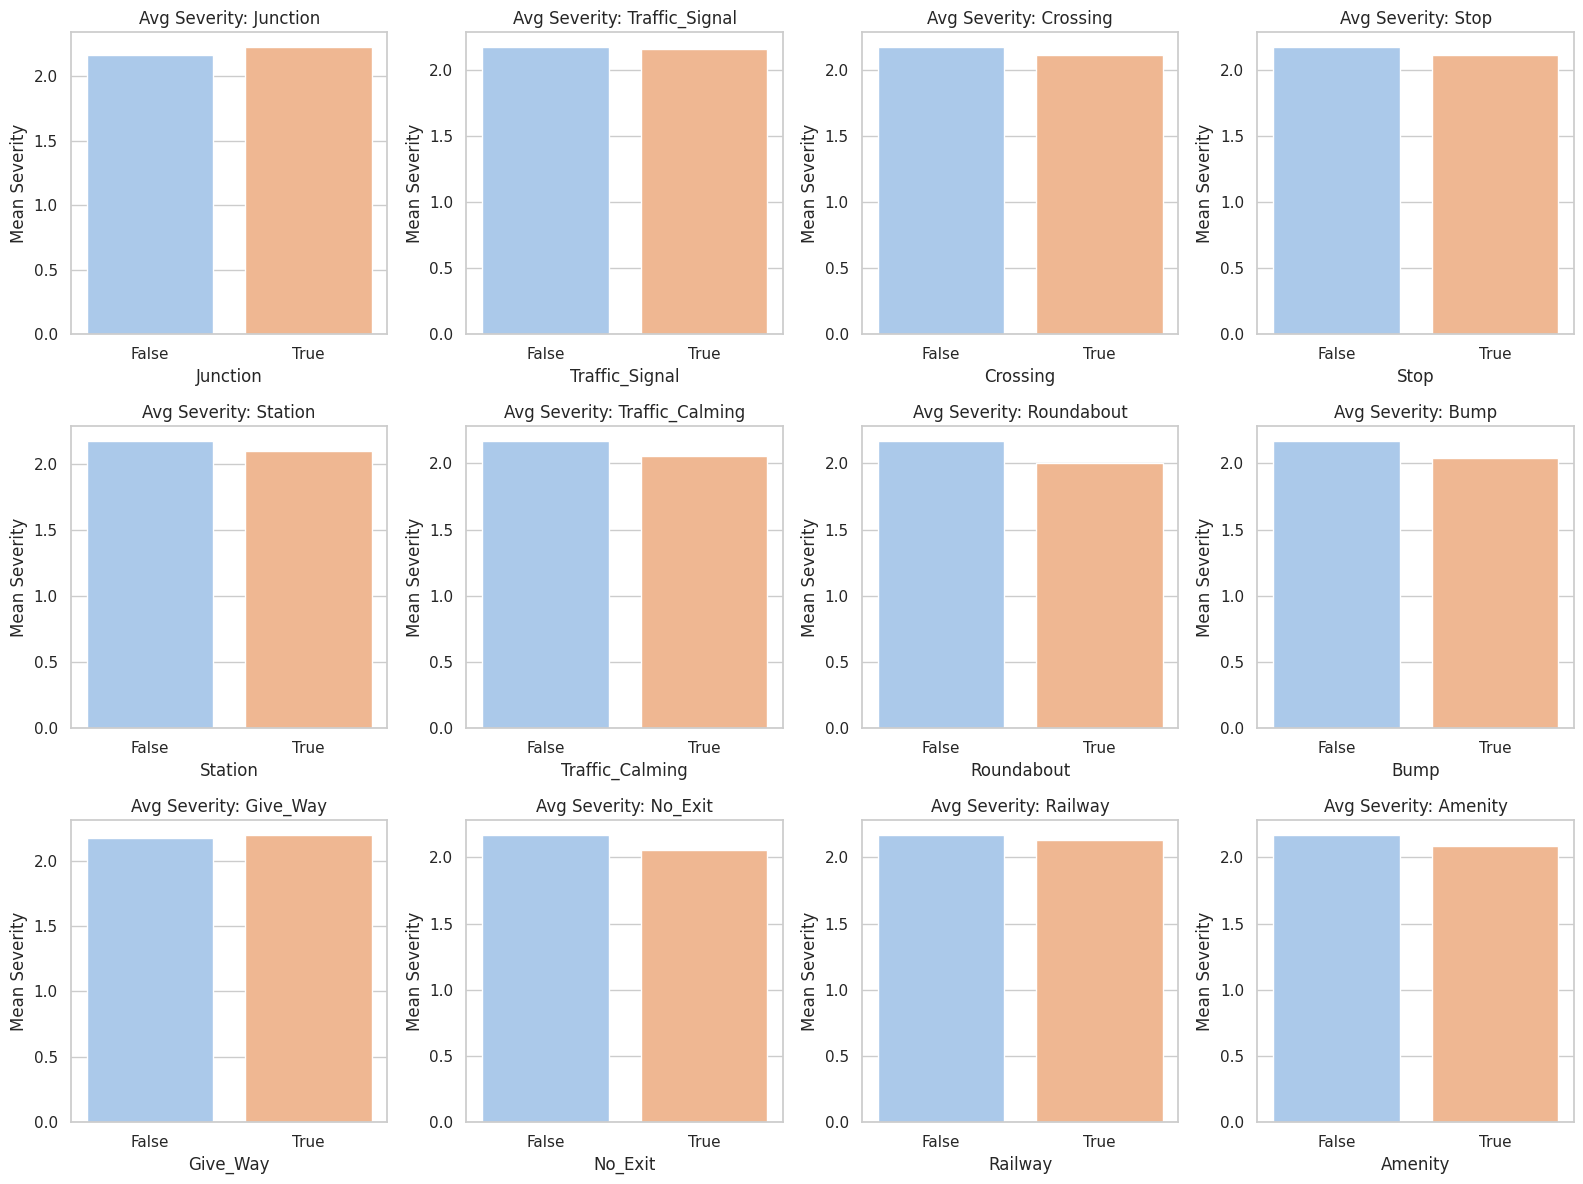

In [ ]:
# Infrastructure features to explore
infra_features = [
    'Junction', 'Traffic_Signal', 'Crossing', 'Stop', 'Station',
    'Traffic_Calming', 'Roundabout', 'Bump', 'Give_Way',
    'No_Exit', 'Railway', 'Amenity'
]

# Set plot style
sns.set(style='whitegrid')
plt.figure(figsize=(16, 12))

# Create subplots: 3x4 grid for 12 features
for idx, feature in enumerate(infra_features, start=1):
    plt.subplot(3, 4, idx)
    sns.barplot(
        data=sample_df_cleaned,
        x=feature, y='Severity',
        estimator=lambda x: sum(x)/len(x), ci=None,
        palette='pastel'
    )
    plt.title(f'Avg Severity: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Mean Severity')

plt.tight_layout()
plt.show()


Documentation: Most infrastructure features show very little variation in average severity (around 2.1 to 2.2).
Some features like Traffic_Calming, Bump, Roundabout show slightly lower average severity, which aligns with the idea that these features reduce speed. Traffic calming features help reduce severity (subtle but valid finding)


In [ ]:
# Set up figure with 2 subplots
plt.figure(figsize=(12, 5))

# --- Left Plot: Severity Distribution (Countplot) ---
plt.subplot(1, 2, 1)
sns.countplot(data=sample_df_cleaned, x='Traffic_Signal', hue='Severity', palette='Set2')
plt.title('Severity Distribution\nWith vs Without Traffic Signals')
plt.xlabel('Traffic Signal Present')
plt.ylabel('Accident Count')
plt.legend(title='Severity')

# --- Right Plot: Average Severity (Barplot) ---
plt.subplot(1, 2, 2)
sns.barplot(data=sample_df_cleaned, x='Traffic_Signal', y='Severity', palette='Blues')
plt.title('Average Severity\nWith vs Without Traffic Signal')
plt.xlabel('Traffic Signal Present')
plt.ylabel('Average Severity')

# Final layout
plt.tight_layout()
plt.show()


- Graph 1: Most accidents occur without a traffic signal, which is expected due to prevalence. Severity = 2 dominates across both groups. The proportion of severe accidents (level 3 and 4) doesn’t dramatically shift between groups.
- Graph 2: Average Severity with vs. without Traffic Signal: shows that average severity is virtually the same with/without traffic signals. So the presence of a signal doesn’t impact acreage accident severity.

Together, the plots show that while traffic signals may influence traffic volume or frequency of accidents, they do not appear to have a strong effect on the severity of those accidents.
**Note:** The imbalance in traffic signal presence may obscure differences.


## 6. Statistical Data Analysis
Please see all documentation on methodology, assumptions, limitations and interpretation in separate document here: https://docs.google.com/document/d/1HyydGsO-7zTStmnr87Dsfziahlinou82jwyzUGFgnmo/edit?usp=sharing

### 6.1 Stats Analysis for Question 1: When and Where do Accidents Most Occur?

In [ ]:
from scipy.stats import chisquare
# Count number of accidents per hour
hour_counts = sample_df_cleaned['Hour'].value_counts().sort_index()

# Chi-square test: compare observed to uniform expected
observed = hour_counts.values
expected = [sum(observed) / len(observed)] * len(observed)

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print(f"Chi-square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# Optional: visualize the distribution
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Accidents by Hour of Day')
plt.xlabel('Hour (0–23)')
plt.ylabel('Accident Count')
plt.show()

In [ ]:
# Count number of accidents per day of week
day_counts = sample_df_cleaned['DayOfWeek'].value_counts().sort_index()

# Chi-square test: expected is uniform distribution
observed = day_counts.values
expected = [sum(observed) / len(observed)] * len(observed)

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print(f"Chi-square Statistic (Days): {chi2_stat:.4f}")
print(f"P-value: {p_value:.4e}")

# Optional: bar plot
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Accidents by Day of Week')
plt.xlabel('Day')
plt.ylabel('Accident Count')
plt.show()

### 6.2 Stats Analysis for Question 2: Weather Conditions

In [ ]:
#Question 2 Tesst 1: Chi-Square Test of Independence to find correlation between Weather_Group × Severity Category (minor vs. major)

# STEP 1: Create a Severity_Level column with Severity 1-2 as minor and 3-4 and major.

def categorize_severity(sev):
    return 'Minor' if sev <= 2 else 'Major'

sample_df_cleaned['Severity_Level'] = sample_df['Severity'].apply(categorize_severity)

# STEP 2: Build contingency table
contingency_table = pd.crosstab(sample_df_cleaned['Weather_Group'], sample_df_cleaned['Severity_Level'])
  #Weather Group contains 7 types: "clear" "cloudy" "rain/drizzle" "rare" "fog/mist/smoke" "snow/ice" and "storm"

# STEP 3: Perform Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# STEP 4: Output results
print("Chi-square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)

"""Results: p>0.05 -> There is actually no statistically significant association between weather group and accident severity, based on this test. """

In [ ]:
# Question 2 Test 2: ANOVA test on the correlation between visibility and severity

# Drop NA values in Visibility or Severity
df_anova = sample_df_cleaned[['Visibility(mi)', 'Severity']].dropna()

# Create visibility samples by severity level
group_1 = df_anova[df_anova['Severity'] == 1]['Visibility(mi)']
group_2 = df_anova[df_anova['Severity'] == 2]['Visibility(mi)']
group_3 = df_anova[df_anova['Severity'] == 3]['Visibility(mi)']
group_4 = df_anova[df_anova['Severity'] == 4]['Visibility(mi)']

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group_1, group_2, group_3, group_4)

print("ANOVA F-Statistic:", f_stat)
print("P-value:", p_value)

"""Results: p>0.0.5 -> The average visibility does not differ significantly across different severity levels (1–4)"""

In [ ]:
# Test 3: Chi-square Test for question: "Does a compound visibility-perception hazard (poor weather, low visibility and nighttime) increase the likelihood of a severe accident?"

# Create a set of weather types that impair visibility
impairing_weather = ['Rain/Drizzle', 'Fog/Mist/Smoke', 'Snow/Ice', 'Storm']

# Define compound condition: visibility < 0.25 miles, night, AND impairing weather
sample_df_cleaned['Perception_Risk'] = (
    (sample_df_cleaned['Visibility(mi)'] < 0.25) &
    (sample_df_cleaned['Is_Night']) &
    (sample_df_cleaned['Weather_Group'].isin(impairing_weather))
)

#Already created severity bins above

# Create crosstab of perception risk vs severity level
ct = pd.crosstab(sample_df_cleaned['Perception_Risk'], sample_df_cleaned['Severity_Level'])

# Run Chi-square test
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)

"""
Results: p>0.05
-> the perception risk condition (low visibility + night + poor weather) is not statistically associated with higher accident severity in this dataset.
Even though these conditions seem dangerous, accidents that occur under them do not appear to be more severe — at least not in a way that’s statistically significant.
"""

### 6.3 Stats Analysis for Question 3: Road Features

In [ ]:
# Step 1: List of infrastructure features
features = [
    'Junction', 'Traffic_Signal', 'Crossing', 'Stop', 'Station',
    'Traffic_Calming', 'Roundabout', 'Bump', 'Give_Way', 'No_Exit',
    'Railway', 'Amenity'
]

# Step 2: Run t-tests and collect results
results = []

for feature in features:
    group_true = sample_df_cleaned[sample_df_cleaned[feature] == True]['Severity']
    group_false = sample_df_cleaned[sample_df_cleaned[feature] == False]['Severity']

    # Independent two-sample t-test (assuming normal-like ordinal Severity)
    stat, pval = ttest_ind(group_true, group_false, equal_var=False)  # Welch's t-test is safer

    results.append({
        'Feature': feature,
        'Mean (True)': group_true.mean(),
        'Mean (False)': group_false.mean(),
        'Mean Diff': group_true.mean() - group_false.mean(),
        'p-value': pval
    })

# Step 3: Convert to DataFrame
ttest_results = pd.DataFrame(results).sort_values('p-value')

# Step 4: Sort by absolute value of mean difference
ttest_results_sorted_by_diff = ttest_results.reindex(ttest_results['Mean Diff'].abs().sort_values(ascending=False).index)
display(ttest_results_sorted_by_diff)

"""Results: Accidents occurring near traffic calming features like bumps, stations, and crossings show significantly lower severity, while those at junctions tend to be more severe, highlighting clear infrastructure-related safety impacts."""

,Feature,Mean (True),Mean (False),Mean Diff,p-value
6,Roundabout,2.000000,2.171286,-0.171286,NaN
7,Bump,2.037037,2.171367,-0.134330,1.239020e-03
5,Traffic_Calming,2.052632,2.171388,-0.118757,2.596268e-03
9,No_Exit,2.053763,2.171540,-0.117776,6.463572e-05
11,Amenity,2.088838,2.172142,-0.083304,5.087471e-06
4,Station,2.095142,2.173094,-0.077952,8.522360e-10
2,Crossing,2.110445,2.176748,-0.066303,1.279162e-18
0,Junction,2.231005,2.165233,0.065772,1.341842e-13
3,Stop,2.112690,2.172672,-0.059982,2.675765e-05
10,Railway,2.128049,2.171618,-0.043569,7.816135e-02


'Results: Accidents occurring near traffic calming features like bumps, stations, and crossings show significantly lower severity, while those at junctions tend to be more severe, highlighting clear infrastructure-related safety impacts.'

In [ ]:
#save ttest_results as csv for tableau
ttest_results.to_csv("ttest_results.csv", index=False)

#download csv to local
from google.colab import files
files.download("ttest_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7. Evaluation: Business Insights and Recommendations


### 1: Target High-Risk Hours with Focused Enforcement and Awareness Campaigns

The Chi-square goodness-of-fit test showed a statistically significant difference in accident frequency across hours (p < 0.001). Accidents spike during 7–9 AM and 3–6 PM, corresponding to morning and evening rush hours. Similarly, accidents spike on Fridays on Thursdays, potentially due to near-end-of-week fatigue and a mix of work-related and leisure-related trips on Fridays.

- **Recommendation:** Deploy targeted traffic enforcement, signal optimization, and public safety campaigns during peak accident windows. Examples include:
  - Increasing traffic patrol visibility
  - Dynamic signage showing crash stats or speeding reminders
  - Running commuter-focused safety ads on radio/social media

- **Potential Impact:**
  - Lower accident rates during peak congestion
  - Reduced emergency response strain
  - Safer commute windows for millions of drivers

- **Challenges:**
  - Enforcement budget and staffing constraints
  - Potential for commuter pushback on increased policing

- **Effectiveness Metrics:**
  - Accident count during peak windows (before vs. after)
  - Response times and congestion levels
  - Public compliance (speeding tickets, seatbelt use, etc.)



### 2: Shift Focus from Severity to Frequency in Low-Visibility Conditions

Despite intuitive expectations, none of the environmental condition tests (weather, visibility, night) showed a statistically significant relationship with severity of accidents (p > 0.05). However, EDA showed high accident counts under poor conditions.

- **Recommendation:** Focus not on severity, but on preventing crash frequency in dangerous perception environments (e.g., foggy nights). Actions include:
  - Automated warning systems (e.g., fog sensors triggering flashing signs)
  - Adaptive lighting in poor-visibility zones
  - Enforce lower speed limits during hazardous conditions

- **Potential Impact:**
  - Reduction in total crash volume under poor conditions
  - Smoother emergency response and less multi-vehicle pileups
  - Increased driver attentiveness in high-risk scenarios

- **Challenges:**
  - Rare conditions may limit sample size and data coverage
  - Drivers may ignore passive warnings

- **Effectiveness Metrics:**
  - Number of crashes under visibility-impaired conditions
  - Driver behavior metrics (average speed, lane deviation)
  - Post-installation compliance with speed reduction signage



### 3: Redesign High-Severity Junctions and Expand Traffic Calming Zones

T-tests showed that accidents near junctions have higher severity, while those near traffic calming features (e.g., speed bumps, dead ends) have lower severity (p < 0.05).

- **Recommendation:**
  - Redesign dangerous intersections with roundabouts, protected turns, or smart signals.
  - Expand calming features in high-risk corridors, especially near schools, hospitals, and commercial zones.

- **Potential Impact:**
  - Fewer severe injuries and fatalities
  - Smoother traffic flow and improved driver awareness
  - Better pedestrian safety in mixed-use areas

- **Challenges:**
  - Infrastructure cost and public resistance to changes (e.g., roundabouts)
  - Time-consuming design and construction phases

- **Effectiveness Metrics:**
  - Mean severity score at redesigned locations
  - Accident count and injury rates at treated vs. untreated sites
  - Speed and traffic flow data post-implementation



## 8. Tableau Dashboard
[Link](https://public.tableau.com/app/profile/jia.li1741/viz/USTrafficAccidentsAnalysis_17523741337980/1_FrequencyPattern?publish=yes)

## Conclusion and Next Steps
The analysis surfaces clear, evidence-backed opportunities to reduce accident risk and improve infrastructure effectiveness. With U.S. traffic accidents costing billions annually, even marginal improvements can translate into substantial **economic and human benefits.**

**Key Recommendations:**
1. Deploy targeted enforcement and education during identified high-risk hours and days (Friday and Thursday in particular).
2. Redesign high-severity intersections and expand traffic calming infrastructure.
3. Improve weather-based protocols to reduce crash likelihood even if severity is unaffected.

**Next Steps:**

- Pilot Testing: Implement and monitor interventions in selected high-risk corridors and timeframes.
- Stakeholder Engagement: Share insights with DOT, planners, emergency services, and law enforcement to align priorities.
- Technology Integration: Use insights to inform regulation and deployment of autonomous vehicle features and driver-assistance systems.
- Further Research: Expand analysis to consider crash frequency, multi-factor interactions, and regional differences.

This project equips stakeholders with the data and direction needed to make **informed, cost-effective safety decisions**—advancing both public welfare and infrastructure strategy.